#Keyboard Biometrics

## SVM Approach

### Problem Background

The problem explored in this project is the identification of a given user based on their typing patterns. Here, we used 3 datasets (found in the data folder under the names 'keystroke0' (the CMU dataset), 'keystroke1' (the standard dataset), 'keystroke2' (the multi-password dataset), and 'keystroke3' (the demographics dataset). The latter 3 come from the [GREYC](http://www.epaymentbiometrics.ensicaen.fr/greyc-keystroke-dataset) lab.

In this project, we will run an SVM classifier on several configurations. First, we will attempt to use an n-class classifier, where n is the number of users in total for the dataset. Here we will try to precisely detect from the test set which of the n users it came from. 

Next, we will run a two-class classifier, in an attempt to determine with a simple binary whether the input provided has come from the genuine user or from one of the impostors. This is a simpler problem because it does not need to be as specific, but it is more practical for real-world applications as keyboard biometrics are really only interesting for ensuring that the typist of the password is in fact the authenticated user.

Finally, we want to detect not only the proportion of time that the classifier gets the correct answer with respect to the genuine user and the impostor, but also to actually focus in on the false positives (when an impostor gets in) and the false negatives (when the genuine user is erroneously blocked from the system). For this portion, we will attempt to construct an ROC curve to visually present the true and false positive rates for the detections.

### SVM Background

Support vector machines (SVMs) are supervised learning models. Given a set of training examples, each marked for belonging to one of two categories, an SVM training algorithm encodes every input as some p-dimensional vector and computes a (p-1)-dimensional hyperplane to separate these points into two groups. New datapoints are then assigned a similar p-dimensional vector which then falls one one or the other side of the hyperplane and the point is thus classified. 

The SVM creates a margin spearating the data. The margin is defined by the distance from the hyperplane to the nearest point on either side of the hyperplane. If the data is linearly separable, it will be possible to create a "hard amrgin" meaning the data will be evenly split into two halves and there will be no data in the margin at all. This is a very good classifier but the data is not always this nice. More commonly, a "soft margin" is used which simply has a penalty factor on the points that fall within the margin and minimizes this penalty to determine the best hyperplane. 

The hyperplane's shape is determined by the "kernel" function used. The kernel can be linear, polynomial, or using a Gaussian radial basis function (rbf). Using a kernel will morph the plane from a linear shape to some curve which will often allow for better classification depending on the type of data and the parameters of the curve.

For multi-class classification, we use the standard dual-class SVM but take a one vs all or a one vs one approach to detemine the one class that the given test data point fits best. In one vs all, n classifiers are created to compare the class x vs the other classes. The test point is run through each of these classifiers and the one with the highest probability of being in the class rather than being in the impostor group wins. In one vs one, each class is pitted against the others and a winner-takees-all strategy is employed until the best one is found.

### SVM for Biometrics

SVMs have been proven good for text categorization problems and bioinformatics. They are also known to perform well for large datasets. They are best for linearly separable data, though it's not certain whether the datasets looked at in this project have this quality.


In [51]:
%matplotlib inline
import csv
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

In [11]:
def score(clf, X_test, y_test):
    idx = 0
    score = 0
    for x in X_test:
        y_pred = clf.predict([x])
        if y_pred == y_test[idx]:
            score += 1
        idx+=1
    return 100*score/idx

### Dataset 1 - CMU

#### Background

This is the basic dataset used in many keyboard biometrics studies. It contains 51 users and 20,400 total rows

#### Preprocessing the data

In [69]:
filename = "../data/keystroke0.csv"

In [70]:
X = []
y = []

with open(filename, 'rb') as f:
    reader = csv.reader(f)
    first = 1
    for row in reader:
        if first:
            first = 0
            continue
        X.append(row[3:])
        y.append(int(row[0][1:]))
print X[:3]
print y[:3]
print type(X), type(X[0]), type(X[0][0])

[['0.1491', '0.3979', '0.2488', '0.1069', '0.1674', '0.0605', '0.1169', '0.2212', '0.1043', '0.1417', '1.1885', '1.0468', '0.1146', '1.6055', '1.4909', '0.1067', '0.7590', '0.6523', '0.1016', '0.2136', '0.1120', '0.1349', '0.1484', '0.0135', '0.0932', '0.3515', '0.2583', '0.1338', '0.3509', '0.2171', '0.0742'], ['0.1111', '0.3451', '0.2340', '0.0694', '0.1283', '0.0589', '0.0908', '0.1357', '0.0449', '0.0829', '1.1970', '1.1141', '0.0689', '0.7822', '0.7133', '0.1570', '0.7877', '0.6307', '0.1066', '0.1684', '0.0618', '0.1412', '0.2558', '0.1146', '0.1146', '0.2642', '0.1496', '0.0839', '0.2756', '0.1917', '0.0747'], ['0.1328', '0.2072', '0.0744', '0.0731', '0.1291', '0.0560', '0.0821', '0.1542', '0.0721', '0.0808', '1.0408', '0.9600', '0.0892', '0.6203', '0.5311', '0.1454', '0.7195', '0.5741', '0.1365', '0.2931', '0.1566', '0.1621', '0.2332', '0.0711', '0.1172', '0.2705', '0.1533', '0.1085', '0.2847', '0.1762', '0.0945']]
[2, 2, 2]
<type 'list'> <type 'list'> <type 'str'>


#### Multi-class SVM

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC(C = 1)
clf.fit(X_train, y_train) 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [16]:
print(str(score(clf, X_test, y_test)) + '%')

39%


In [17]:
# Test different Csprint(str(score(clf, X_test, y_test)) + '%')
results = []
Cs = [1,25,50,75,100]

for i in [1,25,50,75,100]:
    results.append(score(svm.SVC(C = i).fit(X_train, y_train), X_test, y_test))
    
print(Cs)
print(results)

[1, 25, 50, 75, 100]
[39, 79, 82, 83, 84]


In [18]:
# Test different kernels

for i in ['linear','rbf','poly','sigmoid']:
    print(i + ': ' + str(score(svm.SVC(kernel = i).fit(X_train, y_train), X_test, y_test)) + '%')

linear: 76%
rbf: 39%
poly: 2%
sigmoid: 1%


#### Genuine vs Impostor SVM

In [30]:
genuines = [2, 5, 13, 39]
ys = []
for g in genuines:
    # Genuine = 1, Impostor = 0
    newY = []
    for elt in y:
        if elt == g:
            newY.append(1)
        else:
            newY.append(0)
    ys.append(newY)

In [31]:
# Make sure we have exactly 400 1s in each list
for i in range(len(genuines)):
    print(sum(ys[i]))

400
400
400
400


In [34]:
scores = []
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = svm.SVC(C = 1)
    clf.fit(X_train, y_train) 
    scores.append(str(score(clf, X_test, y_test)) + '%')

Weird..

In [35]:
scores

['98%', '98%', '98%', '98%']

#### ROC Curve

Below is the basic code for creating some ROC curves. In this test I just made 6 different "folds", or cross-validation splits and compared them against each other. Ideally we would be comparing different C values, kernels, and datasets using this

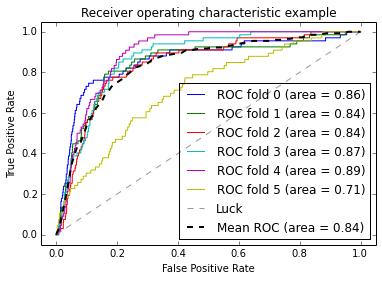

In [52]:
# Gonna just use the first y since it doesn't seem to matter
yyy = np.array(ys[0])
XXX = np.array(X)

# More intense cross-validation
cv = StratifiedKFold(yyy, n_folds=6)
classifier = svm.SVC(kernel='linear', probability=True)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(XXX[train], yyy[train]).predict_proba(XXX[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(yyy[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Dataset 2 - GREYC Standard

#### Background

This is the standard GREYC dataset. It contains 133 users and 7,555 total rows

#### Preprocessing the data

In [84]:
filename = "../data/keystroke1.csv"

In [97]:
X = []
y = []

with open(filename, 'rb') as f:
    reader = csv.reader(f)
    first = 1
    for row in reader:
        if first:
            first = 0
            continue
        rw = map(lambda x: x/10000000., (map(int, row[5].split(' ')[1:61])))
        if len(rw) < 60:
            continue
        X.append(rw)
        y.append(int(row[0]))
print X[:3]
print y[:3]

[[0.1301872, 0.2403456, 0.100144, 0.200288, 0.0701008, 0.1602304, 0.0600864, 0.0701008, 0.0701008, 0.0600864, 0.0400576, 0.3705328, 0.2303312, 0.0701008, 0.1201728, 0.1602304, 0.1101584, 0.2804032, 0.050072, 0.2203168, 0.1101584, 0.1301872, 0.0600864, 0.0600864, 0.100144, 0.0701008, 0.050072, 0.3304752, 0.2103024, 0.100144, 0.0600864, 0.2103024, 0.0200288, 0.150216, -0.0300432, 0.1201728, -0.0300432, 0.0200288, -0.050072, -0.0400576, -0.0300432, -0.0701008, -0.100144, 0.2203168, 0.1201728, -0.0200288, 0.0, 0.100144, 0.2203168, 0.3705328, 0.1802592, 0.300432, 0.2103024, 0.2703888, 0.1702448, 0.1702448, 0.200288, 0.200288, 0.1902736, 0.4806912], [0.1301872, 0.2403456, 0.150216, 0.1301872, 0.0801152, 0.150216, 0.0600864, 0.0801152, 0.0901296, 0.0, 0.0200288, 0.1902736, 0.1902736, 0.0300432, 0.1301872, 0.100144, 0.150216, 0.25036, 0.100144, 0.150216, 0.100144, 0.1301872, 0.1301872, 0.0, 0.0801152, 0.0400576, 0.0901296, 0.0901296, 0.1602304, 0.100144, 0.0600864, 0.1402016, 0.0300432, 0.1201

#### Multi-class SVM

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC(C = 1)
clf.fit(X_train, y_train) 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#####This actually takes a stupid long time to run..

In [99]:
print(str(score(clf, X_test, y_test)) + '%')

0%


### Dataset 4 - GREYC Demographics

#### Background

This is the GREYC dataset where users are also classfified by demographics. It contains 110 users and each has a binary class assigned to them based on age (younger or older than 30), gender, and handedness.

The data is actually split into 2 files - 'keystroke3-1.csv' and 'keystroke3-2.csv'

Each of these has the typing of a different password

#### Preprocessing the data

In [ ]:
filename = "../data/keystroke3-1.csv"

In [100]:
X = []
y = []

with open(filename, 'rb') as f:
    reader = csv.reader(f)
    first = 1
    for row in reader:
        if first:
            first = 0
            continue
        rw = map(lambda x: x/10000000., (map(int, row[6].split(' ')[1:61])))
        if len(rw) < 5:
            print rw
        X.append(rw)
        y.append(int(row[0]))
print X[:3]
print y[:3]

ValueError: invalid literal for int() with base 10: 'greyc'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC(C = 1)
clf.fit(X_train, y_train) 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [ ]:
print(str(score(clf, X_test, y_test)) + '%')

### Dataset 3 - GREYC Multi-password

#### Background

This is the GREYC dataset where users typed multiple passwords. It contains 118 users, each with a unique password. This dataset is complex in its organization and should only be used as a stretch goal - for each password it has the user info for that password and also impostor info for trying to get at the password. Everything here lives in keystroke3.tar.gz

The associated paper that uses this dataset can he found [here](http://arxiv.org/pdf/1207.0784.pdf) 
It's not worth looking into this until we've done good work on the other datasets

#IGNORE BELOW THIS POINT, ALL SCRATCHWORK

In [ ]:
import csv
import numpy as np
import sqlite3
from sklearn import svm
from sklearn.cross_validation import train_test_split

In [112]:
filename = "../data/DSL-StrongPasswordData.csv"

In [122]:
specs = []
users = []

with open(filename, 'rb') as f:
    reader = csv.reader(f)
    first = 1
    for row in reader:
        if first:
            first = 0
            continue
        specs.append(row[3:])
        users.append(int(row[0][1:]))

ValueError: invalid literal for int() with base 10: ''

In [114]:
users

[]

In [115]:
specs

[]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(specs, users, test_size=0.2, random_state=42)

In [117]:
y_train

[]

In [118]:
X_train, X_test, y_train, y_test = train_test_split(specs, users, test_size=0.2, random_state=42)
clf = svm.SVC()
clf.fit(X_train, y_train) 

ValueError: The number of classes has to be greater than one; got 0

In [119]:
idx = 0
score = 0
for x in X_test:
    y_pred = clf.predict([x])
    if y_pred == y_test[idx]:
        score += 1
    idx+=1
print str(100*score/idx) + "%"

ZeroDivisionError: integer division or modulo by zero

In [120]:
print score, idx

0 0


In [121]:
np_specs = np.array(X_train).astype(np.float).ravel()
np_users = np.array(y_train)
print np_specs
print np_users
h = 0.02
x_min, x_max = np_specs.min() - 15, np_specs.max() + 16
y_min, y_max = np_users.min() - 15, np_users.max() + 16
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

[]
[]


ValueError: zero-size array to reduction operation minimum which has no identity

In [173]:
filename = "../data/keystroke2.csv"
specs = []
users = []

with open(filename, 'rb') as f:
    reader = csv.reader(f)
    first = 1
    for row in reader:
        if first:
            first = 0
            continue
        split = row[1].split(' ')
        specs.append(list(np.array(split[1:]).astype("float")))
        users.append(int(row[0]))
specs = np.asarray(specs)

In [174]:
specs[:3]

array([ [1301872.0, 2403456.0, 1001440.0, 2002880.0, 701008.0, 1602304.0, 600864.0, 701008.0, 701008.0, 600864.0, 400576.0, 3705328.0, 2303312.0, 701008.0, 1201728.0, 1602304.0],
       [1301872.0, 2403456.0, 1502160.0, 1301872.0, 801152.0, 1502160.0, 600864.0, 801152.0, 901296.0, 0.0, 200288.0, 1902736.0, 1902736.0, 300432.0, 1301872.0, 1001440.0],
       [1001440.0, 2403456.0, 1402016.0, 1702448.0, 801152.0, 1602304.0, 701008.0, 801152.0, 600864.0, 0.0, 400576.0, 2002880.0, 1802592.0, 500720.0, 1502160.0, 1301872.0]], dtype=object)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(specs, users, test_size=0.2, random_state=42)
clf = svm.SVC()
clf.fit(X_train, y_train) 

ValueError: setting an array element with a sequence.